# Libraries Installation

In [4]:
!pip install torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=150808b6c9695383590d5a53018184d149786aad17eb8e1ac854bb3163e5cb18
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric


# Libraries Importing and Defines

In [6]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv ,summary
import random
import sys
import copy
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from tqdm import tqdm
import json
from itertools import combinations
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch_geometric.nn import HeteroConv
from torch_geometric.nn import GATConv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [7]:
PATH_FOLDER = "/content/drive/MyDrive/Darmoth-Cre-Gene-Project"
PATH_CRE_ATTRIBUTES = "Dataset/LZ_cRE_attributes/LZ_chr1.txt"
PATH_CRE_DNA = "Dataset/cRE_DNA/chr1.npy"
PATH_CRE_EDGE = "Dataset/LZ_cREedge/LZ_t4_chr1.txt"

PATH_GENE_ATTRIBUTES = "Dataset/LZ_GeneTSS300_attributes/TSS300_LZ_chr1.txt"
PATH_GENE_DNA = "Dataset/GENE_DNA/chr1.npy"
PATH_GENE_EDGE = "Dataset/LZ_GENE-cRE_edge/Panc_GCindex_chr1.txt"

PATH_CRE_PREDICTION = 'Result/drepreds.pt'

# Making Files and Folders Ready

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
path = PATH_FOLDER
os.chdir(path)

# Reading Data and Generating Datasets

In [10]:
class CreDataset:

    def __init__(self, path_attributes, path_dna, path_edges):
      self.__read_cRE_attributes(path_attributes)
      self.cRE_number_of_nodes = self.cRE_attributes.size()[0]
      self.__read_cRE_DNA_attributes(path_dna)
      self.__read_cRE_is_edge(path_edges)

    def __str__(self):
        ans = ""
        ans += "Number of nodes is: " + str(self.cRE_number_of_nodes) + "\n"
        ans += "Number of edges is: " + str(self.cRE_number_of_edges) + "\n"
        ans += "Number of DNA of each cRE is: " + str(self.cRE_DNA.shape[1]) + "\n"
        ans += "Number of selected attributes of each cRE is: " + str(self.cRE_attributes.shape[1]) + "\n"

        ans+="\n\n\n"
        ans+= "self.edge_pairs.shape" + str(self.edge_pairs.shape)+"\n"
        ans += "self.cRE_edge_matrix" + str(self.cRE_edge_matrix.shape) +"\n"
        ans += "self.cRE_DNA"+str(self.cRE_DNA.shape)+"\n"
        ans  += "self.cRE_attributes" + str(self.cRE_attributes.shape)+"\n"
        ans += "sself.cre_all"+str(self.cre_all.shape)+"\n"

        return ans


    def __read_cRE_attributes(self, path_attributes):

        cRE_attributes_read = pd.read_table(path_attributes, header = None , sep=" ")
        cRE_attributes_selected = cRE_attributes_read.iloc[: , CRE_FEATURE_LIST]
        cRE_attributes_selected.to_numpy()
        self.cRE_attributes = torch.tensor(StandardScaler().fit_transform(cRE_attributes_selected.to_numpy()), dtype=torch.float)
      
    def __read_cRE_DNA_attributes(self, path_dna):
        
        self.cRE_DNA = np.load(path_dna)

    def __read_cRE_is_edge(self, path_edges):

        cRE_edge = pd.read_table(path_edges, header = None, sep=" ")
        self.cRE_number_of_edges = len(cRE_edge)
        cRE_edge = torch.tensor([cRE_edge[:][0], cRE_edge[:][1]], dtype = torch.long)

        self.edge_pairs = cRE_edge
        self.cRE_edge_matrix = 2 * torch.eye(self.cRE_number_of_nodes, self.cRE_number_of_nodes) - 1

        for i in range(int(len(cRE_edge[1]))):
          self.cRE_edge_matrix[cRE_edge[0][i]][cRE_edge[1][i]] = 1
          self.cRE_edge_matrix[cRE_edge[1][i]][cRE_edge[0][i]] = 1
        self.cre_all = torch.cat([self.cRE_attributes, torch.tensor(self.cRE_DNA)], 1)
      


In [11]:
class GeneDataset:

    def __init__(self, path_attributes, path_dna, path_edges,num_of_crE_nodes):
      self.__read_attributes(path_attributes)
      self.number_of_nodes = self.attributes.size()[0]
      self.__read_DNA_attributes(path_dna)
      self.__read_is_edge(path_edges,num_of_crE_nodes)

  

    def __str__(self):
        ans = ""
        ans += "Number of nodes is: " + str(self.number_of_nodes) + "\n"
        ans += "Number of edges is: " + str(self.number_of_edges) + "\n"
        ans += "Number of DNA of each cRE is: " + str(self.DNA.shape[1]) + "\n"
        ans += "Number of selected attributes of each cRE is: " + str(self.attributes.shape[1]) + "\n"
        ans+="\n\n\n"
        ans+= "self.edge_pairs.shape" + str(self.edge_pairs.shape)+"\n"
        ans += "self.edge_matrix" + str(self.edge_matrix.shape) +"\n"
        ans += "self.DNA"+str(self.DNA.shape)+"\n"
        ans  += "self.attributes" + str(self.attributes.shape)+"\n"
        ans += "self.gene_all"+str(self.gene_all.shape)+"\n"

        return ans


    def __read_attributes(self, path_attributes):
        attributes_read = pd.read_table(path_attributes, header = 0 , sep=" ")
        attributes_selected = attributes_read.iloc[: ,GENE_FEATURE_LIST] 
        # attributes_selected.to_numpy()
        self.attributes = torch.tensor(StandardScaler().fit_transform(attributes_selected.to_numpy()), dtype=torch.float)
      
    def __read_DNA_attributes(self, path_dna):
        
        self.DNA = np.load(path_dna)

    def __read_is_edge(self, path_edges,num_of_crE_nodes):

        edge = pd.read_table(path_edges, header = None, sep=" ")
        self.number_of_edges = len(edge)
        edge = torch.tensor([edge[:][0], edge[:][1]], dtype = torch.long)

        self.edge_pairs = edge
        self.edge_matrix = 0-torch.ones(num_of_crE_nodes,self.attributes.size()[0])

        for i in range(int(len(edge[1]))):
          self.edge_matrix[edge[0][i]][edge[1][i]] = 1
        self.gene_all = torch.cat([self.attributes, torch.tensor(self.DNA)], 1)
         

# Adding negative samples to edge matrix

In [12]:
def generate_positive_negative_matrix(cre_dataset,Gene_dataset):

  count_negative = 0

 # have_already_sampled = torch.eye(cre_dataset.cRE_number_of_nodes, Gene_dataset.number_of_nodes) #why diagonal matrix??
  sampled_nodes = set()


  num_node_zero_base = cre_dataset.cRE_number_of_nodes - 1#9945

  number_negative_samples = int(len(Gene_dataset.edge_pairs[1]))#2718
 
  while(count_negative < number_negative_samples):
    
       edge_index_in_matrix = random.randint(0,cre_dataset.cRE_number_of_nodes * Gene_dataset.number_of_nodes-1)
       node1 = edge_index_in_matrix // cre_dataset.cRE_number_of_nodes
       node2 = edge_index_in_matrix % Gene_dataset.number_of_nodes
       if(Gene_dataset.edge_matrix[node1][node2] == -1 and (node1,node2) not in sampled_nodes and node1!=node2):  #why node1!=node2 ??
          Gene_dataset.edge_matrix[node1][node2] =0
          count_negative += 1
          sampled_nodes.add((node1,node2))
          



# Generate Random Subgraph

In [13]:
def generate_random_subgraph(cre_dataset, Gene_dataset):
  

  cre_edge_list_node1 = []
  cre_edge_list_node2 = []

  gene_edge_list_node1 = []
  gene_edge_list_node2 = []


  random_cre_nodes = random.sample(range(crE_dataset.cre_all.shape[0]),k=cREsamplesize)
 
  random_gene_nodes = random.sample(range(Gene_dataset.gene_all.shape[0]),k=genesamplesize)
  
  attribute_dataset = []

  ycRE=[]
  yGENE=[]

  for m in range(cREsamplesize):
    for n in range(genesamplesize):
            yGENE.append(Gene_dataset.edge_matrix[random_cre_nodes[m]][random_gene_nodes[n]])
            if(Gene_dataset.edge_matrix[random_cre_nodes[m]][random_gene_nodes[n]]==1):
                    gene_edge_list_node1.append(m)
                    gene_edge_list_node2.append(n)
    for n in range(cREsamplesize):
            ycRE.append(cRE_prediction[random_cre_nodes[m]][random_cre_nodes[n]])
            if(cRE_prediction[random_cre_nodes[m]][random_cre_nodes[n]]==1):
                cre_edge_list_node1.append(m)
                cre_edge_list_node2.append(n) 

  hetero = HeteroData()
  hetero['cRE'].x= torch.index_select(crE_dataset.cre_all, 0, torch.tensor(random_cre_nodes).long())
  hetero['gene'].x=torch.index_select(Gene_dataset.gene_all, 0, torch.tensor(random_gene_nodes).long())
  hetero['cRE'].y=torch.tensor(ycRE).long()
  hetero['gene'].y=torch.tensor(yGENE).long()
  hetero['cRE','interactswith','cRE'].edge_index=torch.tensor([cre_edge_list_node1,cre_edge_list_node2], dtype=torch.long)
  hetero['cRE','regulates','gene'].edge_index=torch.tensor([gene_edge_list_node1,gene_edge_list_node2], dtype=torch.long)
  return hetero

In [14]:
def generate_subgraphs(cre_dataset, Gene_dataset, number_samples, ratio_test_size):
  dataset_subgraphs = []
  for i in tqdm(range(number_samples)):
    new_subgraph_dataset = generate_random_subgraph(cre_dataset,Gene_dataset)
    dataset_subgraphs.append(new_subgraph_dataset)
  
  dataset_train, dataset_test = train_test_split(dataset_subgraphs, test_size = ratio_test_size, random_state = 42)
  return dataset_train, dataset_test

# Training GNN Model

In [15]:
class gnn_network(torch.nn.Module):

    def __init__(self,  gcn_hidden_size, sample_size):

        super().__init__()

        self.hetero_conv1 = HeteroConv({
            ('cRE','interactswith','cRE'): GCNConv(-1, gcn_hidden_size,add_self_loops=False),
            ('cRE','regulates','gene'): GATConv((-1, -1), gcn_hidden_size,add_self_loops=False),
        }, aggr='sum')
        self.hetero_conv2 = HeteroConv({
            ('cRE','interactswith','cRE'): GCNConv(-1, gcn_hidden_size, add_self_loops=False),
            ('cRE','regulates','gene'): GATConv((-1, -1), gcn_hidden_size, add_self_loops=False),
        }, aggr='mean')

        self.matrix=Variable(torch.randn(gcn_hidden_size,gcn_hidden_size).type(torch.FloatTensor),requires_grad=True)
        self.linear=torch.nn.Linear(1,2)  
        self.sample_size=sample_size

    def forward(self,data):

        x = {'cRE':data['cRE'].x, 'gene': data['gene'].x}
        edge_index = {('cRE','interactswith','cRE'): data['cRE','interactswith','cRE'].edge_index, ('cRE','regulates','gene'): data['cRE','regulates','gene'].edge_index}

        x = self.hetero_conv1(x, edge_index)
        x = self.hetero_conv2(x,edge_index)

        ypred = []
        for i in range(x['cRE'].size(0) // self.sample_size):
        
            cRE_batch = x['cRE'][i*self.sample_size:(i+1)*self.sample_size,:]
            gene_batch = x['gene'][i*self.sample_size: (i+1) * self.sample_size, :]
            ypred.append(self.linear(torch.matmul(torch.matmul(cRE_batch,self.matrix),gene_batch.t()).unsqueeze(-1)).view(-1,2))
        
        
        return torch.stack(ypred).view(-1,2)

In [16]:
def train_gnn_model(gcn_hidden_size,  batch_size, sample_size, 
                    num_epochs, backward_lim, dataset_train, print_model_summary=False):
  

  model=gnn_network(gcn_hidden_size, sample_size)
  
  criterion = torch.nn.CrossEntropyLoss(ignore_index =-1)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
  loader = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
  
  for epoch in range(num_epochs):
    count = 0
    loss = 0
    for data in loader:
        pred_y = model(data)
        loss = loss + criterion(pred_y,  data['gene'].y)
        count = count + 1
        if(count == backward_lim):
            loss.backward()
            optimizer.step()
            print('epoch {}, loss {}'.format(epoch, loss.item()))
            optimizer.zero_grad()
            loss = 0
            count = 0 
      
    if(epoch==0 and print_model_summary):
        print(summary(model,data))

    if(loss != 0):
        loss.backward()
        optimizer.step()
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        optimizer.zero_grad()
   
   
  return model

# Test GNN Model

In [17]:
def test_model(feature_inp, model_cRE_edge_predictior, batch_size, key_input, dataset_test):

  loader = DataLoader(dataset_test, batch_size = batch_size, shuffle=True)

  y_true = []
  y_pred = []

  with torch.no_grad():    
    for data in loader:
      pred_y = model_cRE_edge_predictior(data)
      v, i = torch.max(pred_y, dim = 1)
      y_true += data['gene'].y.tolist()
      y_pred += i

  y_pred_samples = [y_pred[i] for i in range(len(y_pred)) if y_true[i] != -1] 
  y_true_samples = [var for var in y_true if var != -1] 
  f1 = f1_score(y_true_samples, y_pred_samples, average='macro')
  print("f1 score is: ", f1)      

  return y_true, y_pred

# Evaluation prediction results

In [66]:
def evaluate_result(y_pred, y_true):
  
  true_pos=0
  false_neg=0
  new_pos=0
  new_neg=0
  true_neg=0
  false_pos=0

  y_true_classes = []
  y_pred_classes= []


  for i in range(len(y_pred)):
      if(y_true[i] == 1):
          if(y_pred[i] == 1):
              y_true_classes.append(0)
              y_pred_classes.append(0)
              true_pos += 1
              
              
          else:
              false_neg += 1
              y_true_classes.append(1)
              y_pred_classes.append(1)

      elif(y_true[i] == -1):
         
          if(y_pred[i] == 1):
              new_pos += 1
              y_true_classes.append(2)
              y_pred_classes.append(2)
              
          else:
              new_neg += 1
              y_true_classes.append(3)
              y_pred_classes.append(3)

      elif(y_true[i] == 0):
          if(y_pred[i] == 1):
              false_pos += 1
              y_true_classes.append(4)
              y_pred_classes.append(4)

          else:
              true_neg += 1
              y_true_classes.append(5)
              y_pred_classes.append(5)
              
  print("True positive is: ", true_pos)
  print("False negative is: ", false_neg)
  print("New positive is: ", new_pos)
  print("New negative is: ", new_neg)
  print("False positive is: ", false_pos)
  print("True negative is: ", true_neg)


  cf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues_r')

  ax.set_title('Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted')
  ax.set_ylabel('Actual');

  ax.xaxis.set_ticklabels(['1','0','1','0', '1','0'])
  ax.yaxis.set_ticklabels(['1','1','0', '0','-1','-1'])

  #plt.show()
  plt.savefig('Result/GeneCrePredictions_ConfusionMat.png',bbox_inches='tight')
  plt.show() 
  plt.close()
  #plt.imsave('Result/GeneCrePredictions_ConfusionMat.png',Gene_dataset.edge_matrix,cmap='bwr')

Predict whole graph

In [19]:
def predict_edges(cre_dataset,Gene_dataset, model_cRE_edge_predictor, i, j, xcRE,xgene, cRE_prediction, sample_size
                  ):
  
  
  edge_node1, edge_node2 =(cRE_prediction[i*sample_size:(i+1)*sample_size,i*sample_size:(i+1)*sample_size] == 1).nonzero(as_tuple=True) 


  cREedgeindexfrom = cre_dataset.edge_pairs[0].tolist()

  cREedgeindexto =cre_dataset.edge_pairs[1].tolist()

  cREgoldpairs = list(zip(cREedgeindexfrom, cREedgeindexto))

 

  cREgoldsel = [(var[0] - i* sample_size, var[1] - i* sample_size) for var in cREgoldpairs if var[0] >= i* sample_size and var[1] >= i* sample_size and var[0] < (i+1)* sample_size and var[1] < (i+1)* sample_size]


  cREgoldsel += list(zip(edge_node1.tolist(), edge_node2.tolist()))

  cREgoldsel = list(set(cREgoldsel))

  cREgoldselfrom = torch.LongTensor([var[0] for var in cREgoldsel])
  cREgoldselto = torch.LongTensor([var[1] for var in cREgoldsel])

  edge_node1,edge_node2 = (cREgoldselfrom, cREgoldselto)

  GENEedgelista,GENEedgelistb=(Gene_dataset.edge_matrix[i*sample_size:(i+1)*sample_size,j*sample_size:(j+1)*sample_size] == 1).nonzero(as_tuple=True)
  hetero2 = HeteroData()
  hetero2['cRE'].x= torch.index_select(cre_dataset.cre_all, 0, torch.tensor(xcRE).long())
  hetero2['gene'].x=torch.index_select(Gene_dataset.gene_all, 0, torch.tensor(xgene).long())

  hetero2['cRE','interactswith','cRE'].edge_index=torch.stack([edge_node1,edge_node2]).long()
  hetero2['cRE','regulates','gene'].edge_index=torch.stack([GENEedgelista,GENEedgelistb]).long()
 

  pred_y= model_cRE_edge_predictor(hetero2)
  v,ind=torch.max(pred_y,dim=1)
  pred_edge_index = [var[0] - 1 for var in enumerate(ind,1) if var[1] == 1]
  tmp = torch.zeros(100,100)
  for point in pred_edge_index:
            point_x = point // 100
            point_y = point % 100
            tmp[point_x, point_y] = 1


  return tmp
  
  

In [20]:
def predict_whole_graph(cre_dataset,Gene_dataset, model_cRE_edge_predictor,cRE_prediction, sample_size  ):

  prediction = torch.zeros((cre_dataset.cRE_attributes.size()[0]// sample_size+1)* sample_size,(Gene_dataset.attributes.size()[0]// sample_size+1)* sample_size)

  
  for i in tqdm(range(cre_dataset.cRE_attributes.shape[0]//sample_size+1)):
    for j in range(Gene_dataset.attributes.shape[0]//sample_size+1):
        if((i+1)*sample_size > cre_dataset.cRE_attributes.size()[0]):
            xcRE=list(range(i*sample_size,cre_dataset.cRE_attributes.size()[0])) + list(range(sample_size-(cre_dataset.cRE_attributes.size()[0]-(i*sample_size))))
        else:
            xcRE=range(i*sample_size,(i+1)*sample_size)
        if((j+1)*sample_size > Gene_dataset.attributes.size()[0]):
            xgene=list(range(j*sample_size,Gene_dataset.attributes.size()[0])) + list(range(sample_size-(Gene_dataset.attributes.size()[0]-(j*sample_size))))
        else:
            xgene=range(j*sample_size,(j+1)*sample_size)
        tmp=predict_edges(cre_dataset,Gene_dataset, model_cRE_edge_predictor, i, j, xcRE,xgene, cRE_prediction ,sample_size)
        prediction[i* sample_size:(i+1)* sample_size, j* sample_size:(j+1)* sample_size] = tmp
        

  #predict_edges_old_method(cre_dataset, model_cRE_edge_predictor,  x_attributes, NUM_NODES_EACH_PART_PRED,prediction)
  
  return prediction
  #plt.imsave(path_out, prediction,cmap='bwr')

# Hyper Parameters functions

In [21]:
PORTION_HIDDEN_EDGES = 0.1
RATIO_NEGATIVE_SAMPLE_TO_POSITIVE = 5
RADIUS = 250
NUMBER_OF_SAMPLE_DATASET = 1000
RANDOM_SIZE = 100
NEIGHBOR_SIZE = 50
RATIO_TEST_SIZE = 0.2
FEATURE_LIST = [3,5,6,7,8,9,10,11,12,13,14]
BATCH_SIZE = 16
NUMBER_FEATURE_COMB = 11
GCN_INPUT_SIZE = 500
GCN_HIDDEN_SIZE = 300
GCN_OUTPUT_SIZE = 200
NUM_EPOCHS = 200
BACKWARD_LIM = 10
NUM_NODES_EACH_PART_PRED = 100
LIST_FEATURE_INDEX = [10,9,8,7,6,5,4,3,2,1,0]
PATH_PREDICTIONS = "Result/newpred12_0.5.pdf"


CRE_FEATURE_LIST = [3,5,6,7,8,9,10,11,12,13,14]
GENE_FEATURE_LIST=[3,4,5,6,7,8,9,10,11,12,13]
cREsamplesize=100
genesamplesize=100


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [68]:
hyper_parameters = {'portion_hidden_edges': PORTION_HIDDEN_EDGES, 'ratio_negative_to_positive': 1, 
                              'radius': RADIUS, 'number_of_sample_dataset': 1000, 'random_size':  RANDOM_SIZE, 
                              'neighbor_size': NEIGHBOR_SIZE, 'ratio_test_size': RATIO_TEST_SIZE, 'feature_selected': FEATURE_LIST, 
                              'batch_size': BATCH_SIZE, 'number_feature_comb':  NUMBER_FEATURE_COMB, 'gcn_input_size': GCN_INPUT_SIZE, 
                              'gcn_hidden_size': GCN_HIDDEN_SIZE, 'gcn_output_size': GCN_OUTPUT_SIZE, 'number_of_epochs': 100, 
                              'backward_lim': BACKWARD_LIM, 'num_nodes_each_part_pred':  NUM_NODES_EACH_PART_PRED, 'list_feature_index': LIST_FEATURE_INDEX}

# Encapsulate functions running

In [23]:
crE_dataset = CreDataset(PATH_CRE_ATTRIBUTES, PATH_CRE_DNA, PATH_CRE_EDGE)
Gene_dataset = GeneDataset(PATH_GENE_ATTRIBUTES, PATH_GENE_DNA, PATH_GENE_EDGE,crE_dataset.cRE_number_of_nodes)
cRE_prediction=torch.load(PATH_CRE_PREDICTION)

In [24]:
generate_positive_negative_matrix(crE_dataset , Gene_dataset)

In [25]:

dataset_train, dataset_test = generate_subgraphs(crE_dataset, Gene_dataset, hyper_parameters['number_of_sample_dataset'], hyper_parameters['ratio_test_size'])
  

  
  

100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


In [69]:
model_cRE_edge_predictor = train_gnn_model( hyper_parameters['gcn_hidden_size'],
                                              hyper_parameters['batch_size'],
                                             hyper_parameters['random_size'] 
                                             , hyper_parameters['number_of_epochs'],
                                             hyper_parameters['backward_lim'], dataset_train,print_model_summary=True)



epoch 0, loss 736.01171875
epoch 0, loss 651.7122192382812
epoch 0, loss 517.9268188476562
epoch 0, loss 298.96685791015625
epoch 0, loss 303.19830322265625
+----------------------------------------------+-------------------------+----------------+----------+
| Layer                                        | Input Shape             | Output Shape   | #Param   |
|----------------------------------------------+-------------------------+----------------+----------|
| gnn_network                                  | [3200, 3200]            | [160000, 2]    | 973,504  |
| ├─(hetero_conv1)HeteroConv                   |                         |                | 702,300  |
| │    └─(convs)ModuleDict                     | --                      | --             | 702,300  |
| │    │    └─(cRE__interactswith__cRE)GCNConv | [1600, 779], [2, 29228] | [1600, 300]    | 234,000  |
| │    │    └─(cRE__regulates__gene)GATConv    | [2, 14]                 | [1600, 300]    | 468,300  |
| ├─(hetero_conv2)H

f1 score is:  0.9501985579589574
True positive is:  176
False negative is:  20
New positive is:  16814
New negative is:  1982698
False positive is:  3
True negative is:  289


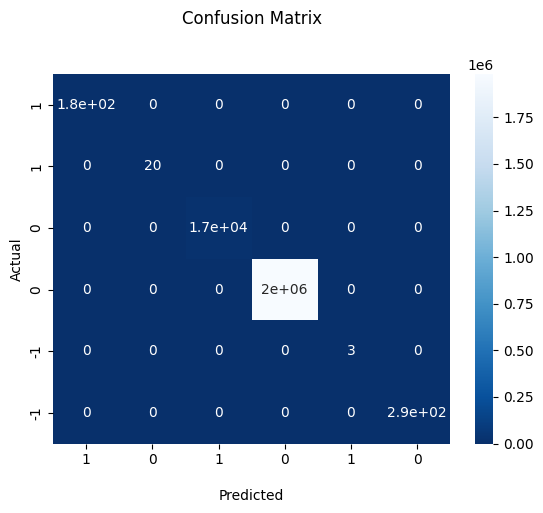

In [70]:
key_list=['A','B','C','D','E','F','G','H','I','J','K']
key_inp = "".join(key_list) 
y_true, y_pred = test_model(hyper_parameters['feature_selected'], model_cRE_edge_predictor, hyper_parameters['batch_size'], key_inp, dataset_test)
evaluate_result(y_pred, y_true)
 


In [30]:
PATH_PREDICTIONS = "Result/Gene_newpred12_0.5.pdf"
prediction_result = predict_whole_graph(crE_dataset,Gene_dataset, model_cRE_edge_predictor, cRE_prediction, hyper_parameters['num_nodes_each_part_pred'])

100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


In [31]:

torch.save(prediction_result, 'Result/genepreds_withknowenedge.pt')
plt.imsave("Result/geneknownplot.pdf",Gene_dataset.edge_matrix,cmap='bwr')

plt.imsave("Result/geneplot-withknownedge.pdf",prediction_result,cmap='bwr')